# Imports

I am going to be building off of my work in prior notebooks to institute grid search to hyperparameter tune for ClimateBERT.

In [ ]:
!pip install tensorflow-datasets==4.8 --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15

!pip install pydot --quiet
!pip install transformers==4.17 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.69 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompati

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install transformers torch --quiet

# Data

Split into train, validation, and test sets. Turn data into tf tensors. Get max_sequence_length for tokenization in next step

In [ ]:
# Get Dataset
gw_sentences_df = pd.read_csv('/content/drive/MyDrive/w266/Final Project/GWStance GWSD.csv', sep='\t')
gw_sentences_df = gw_sentences_df[5:] # remove first five rows; they're screen sentences we use to make sure that annotators correctly understand the task.
gw_sentences_df.head()

,Unnamed: 0,round,batch,sent_id,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,disagree,agree,neutral,guid,in_held_out_test
5,5,1,0,t0,Warmer-than-normal sea surface temperatures ar...,neutral,neutral,neutral,agrees,agrees,agrees,agrees,agrees,0.003105,0.711260,0.285634,1_0_t0,False
6,6,1,0,t1,We will continue to rely in part on fossil fue...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,0.000830,0.001163,0.998006,1_0_t1,False
7,7,1,0,t10,The actual rise in sea levels measured only 1....,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,0.000802,0.001174,0.998023,1_0_t10,False
8,8,1,0,t11,Claims of global warming have been greatly exa...,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,0.997695,0.001171,0.001134,1_0_t11,False
9,9,1,0,t12,The Intergovernmental Panel on Climate Change ...,neutral,disagrees,neutral,neutral,neutral,neutral,neutral,neutral,0.031351,0.002962,0.965687,1_0_t12,False


In [ ]:
# Drop irrelevant columns, split into test and train
gwsd = gw_sentences_df[['sentence', 'agree', 'disagree', 'neutral', 'in_held_out_test']]

# Make fxn to categorize sentiment
def categorize_sentiment(agree, disagree, neutral):
    if disagree > agree and disagree > neutral:
        return 1
    elif neutral > agree and neutral > disagree:
        return 0
    else:
        return 2

# Apply fxn to make 0, 1, 2 for
gwsd['sentiment'] = gwsd.apply(lambda row: categorize_sentiment(row['agree'], row['disagree'], row['neutral']), axis=1)
gwsd.head()

<ipython-input-7-b17ddf060ae2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwsd['sentiment'] = gwsd.apply(lambda row: categorize_sentiment(row['agree'], row['disagree'], row['neutral']), axis=1)


,sentence,agree,disagree,neutral,in_held_out_test,sentiment
5,Warmer-than-normal sea surface temperatures ar...,0.711260,0.003105,0.285634,False,2
6,We will continue to rely in part on fossil fue...,0.001163,0.000830,0.998006,False,0
7,The actual rise in sea levels measured only 1....,0.001174,0.000802,0.998023,False,0
8,Claims of global warming have been greatly exa...,0.001171,0.997695,0.001134,False,1
9,The Intergovernmental Panel on Climate Change ...,0.002962,0.031351,0.965687,False,0


In [ ]:
# Split into train and test sets

train_sentences = gwsd['sentence'][gwsd['in_held_out_test'] == 0]
test_sentences = gwsd['sentence'][gwsd['in_held_out_test'] == 1]

print("Train and test sentence shapes:", train_sentences.shape, test_sentences.shape)

train_sentiment = gwsd['sentiment'][gwsd['in_held_out_test'] == 0]
train_sentiment = tf.convert_to_tensor(train_sentiment, dtype=tf.int32)
test_sentiment = gwsd['sentiment'][gwsd['in_held_out_test'] == 1]
test_sentiment = tf.convert_to_tensor(test_sentiment, dtype=tf.int32)

print("Train and test sentiment shapes:",train_sentiment.shape, test_sentiment.shape)

# Turn into TF Tensors
train_sentences = tf.convert_to_tensor(train_sentences.values, dtype=tf.string)
test_sentences = tf.convert_to_tensor(test_sentences.values, dtype=tf.string)


Train and test sentence shapes: (2095,) (200,)
Train and test sentiment shapes: (2095,) (200,)


In [ ]:
# Get MAX_SEQUENCE_LENGTH
MAX_SEQUENCE_LENGTH = 256 # from paper

print("Max UTF-8 sequence length:", MAX_SEQUENCE_LENGTH)

# Encode and Tokenize train and test sets
train_sentences = [x.decode('utf-8') for x in train_sentences.numpy()]
test_sentences = [x.decode('utf-8') for x in test_sentences.numpy()]

# x_train = bert_tokenizer(train_sentences,
#                          max_length=MAX_SEQUENCE_LENGTH,
#                          truncation=True,
#                          padding='max_length',
#                          return_tensors='tf')
# x_test = bert_tokenizer(test_sentences,
#                         max_length=MAX_SEQUENCE_LENGTH,
#                         truncation=True,
#                         padding='max_length',
#                         return_tensors='tf')

Max UTF-8 sequence length: 256


# Tokenize and Make create_model function

We're going to tokenize and make the create_model function.

In [ ]:
# Load Climate BERT tokenizer and model
from transformers import AutoTokenizer, TFAutoModel

climatebert_tokenizer = AutoTokenizer.from_pretrained("climatebert/distilroberta-base-climate-f")
climatebert_model = TFAutoModel.from_pretrained('climatebert/distilroberta-base-climate-f', from_pt=True)
checkpoint_2 = 'climatebert/distilroberta-base-climate-f'


Downloading:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.05M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

In [ ]:
# Tokenize
x_train = climatebert_tokenizer(train_sentences,
                         max_length=MAX_SEQUENCE_LENGTH,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf')
x_test = climatebert_tokenizer(test_sentences,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

In [ ]:
# define the climate bert model

def create_climatebert_multiclass_model(checkpoint = checkpoint_2,
                                        num_classes = 3,
                                        hidden_size = 201,
                                        dropout=0.3,
                                        learning_rate=0.00005,
                                        pooler=True):
    """
    Build a simple classification model with BERT. Use the Pooler Output of CLS token for classification purposes.
    """
    # fresh model instance
    climatebert_model = TFAutoModel.from_pretrained('climatebert/distilroberta-base-climate-f', from_pt=True) # fresh instance of model

    # get a Climate BERT model with input checkpoint and make fully traininable
    climatebert_model.trainable = True

    # make input layers
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask_layer')

    # BERT
    bert_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}

    bert_out = climatebert_model(bert_inputs)

    # get pooler and cls token
    if pooler:
      token = bert_out[1] #pooler token
    else:
      token = bert_out[0][:, 0, :] #CLS token

    # HIDDEN LAYER
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(token)

    # DROPOUT
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # CLASSIFICATION
    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')


    ### END YOUR CODE
    return classification_model

# Hyperparameter Tuning

## GridSearch

I'm going to implement GridSearch for dropout rate, learning rate, and pooler/CLS token options.

In [ ]:
import itertools
import numpy as np
from sklearn.model_selection import train_test_split

# Define parameter grid
dropout_values = [0.2, 0.3, 0.4, 0.5]
learning_rate_values = [0.00001, 0.00002, 0.00003, 0.00004, 0.00005]
pooler_values = [True, False]

param_grid = list(itertools.product(dropout_values, learning_rate_values, pooler_values))

# Results storage
results = []

# Perform Grid Search
for dropout, learning_rate, pooler in param_grid:
    print(f"Training with dropout={dropout}, learning_rate={learning_rate}, pooler={pooler}")

    # Create model
    model = create_climatebert_multiclass_model(
        checkpoint=checkpoint_2,  # Adjust if needed
        num_classes=3,
        hidden_size=201,
        dropout=dropout,
        learning_rate=learning_rate,
        pooler=pooler
    )

    # Train model
    history = model.fit([x_train.input_ids, x_train.attention_mask],
                        train_sentiment,
                        validation_split=0.1, # split 10% of data for validation
                        batch_size=8,
                        epochs=1)

    # Record results
    val_acc = history.history['val_accuracy'][-1]
    results.append({
        'dropout': dropout,
        'learning_rate': learning_rate,
        'pooler': pooler,
        'val_accuracy': val_acc
    })

Training with dropout=0.2, learning_rate=1e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 331ms/step - loss: 0.9132 - accuracy: 0.5660 - val_loss: 0.7674 - val_accuracy: 0.6333
Training with dropout=0.2, learning_rate=1e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 341ms/step - loss: 0.9330 - accuracy: 0.5549 - val_loss: 0.7369 - val_accuracy: 0.6667
Training with dropout=0.2, learning_rate=2e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 343ms/step - loss: 0.8216 - accuracy: 0.6430 - val_loss: 0.7375 - val_accuracy: 0.6905
Training with dropout=0.2, learning_rate=2e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 100s 344ms/step - loss: 0.8966 - accuracy: 0.5825 - val_loss: 0.7518 - val_accuracy: 0.6190
Training with dropout=0.2, learning_rate=3e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 100s 342ms/step - loss: 0.8081 - accuracy: 0.6408 - val_loss: 0.7290 - val_accuracy: 0.6714
Training with dropout=0.2, learning_rate=3e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 98s 342ms/step - loss: 0.8554 - accuracy: 0.6048 - val_loss: 0.8256 - val_accuracy: 0.6238
Training with dropout=0.2, learning_rate=4e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 100s 341ms/step - loss: 0.8024 - accuracy: 0.6456 - val_loss: 0.6892 - val_accuracy: 0.6952
Training with dropout=0.2, learning_rate=4e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 98s 341ms/step - loss: 0.8489 - accuracy: 0.6074 - val_loss: 0.7472 - val_accuracy: 0.6762
Training with dropout=0.2, learning_rate=5e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 100s 344ms/step - loss: 0.8263 - accuracy: 0.6170 - val_loss: 0.7449 - val_accuracy: 0.6571
Training with dropout=0.2, learning_rate=5e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 342ms/step - loss: 0.8037 - accuracy: 0.6308 - val_loss: 0.7174 - val_accuracy: 0.7000
Training with dropout=0.3, learning_rate=1e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 98s 341ms/step - loss: 0.9249 - accuracy: 0.5560 - val_loss: 0.7885 - val_accuracy: 0.6381
Training with dropout=0.3, learning_rate=1e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 101s 343ms/step - loss: 0.9826 - accuracy: 0.5066 - val_loss: 0.7929 - val_accuracy: 0.6333
Training with dropout=0.3, learning_rate=2e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 100s 348ms/step - loss: 0.8477 - accuracy: 0.6090 - val_loss: 0.6954 - val_accuracy: 0.6857
Training with dropout=0.3, learning_rate=2e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 344ms/step - loss: 0.8896 - accuracy: 0.5618 - val_loss: 0.7056 - val_accuracy: 0.6762
Training with dropout=0.3, learning_rate=3e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 101s 344ms/step - loss: 0.8549 - accuracy: 0.6058 - val_loss: 0.7505 - val_accuracy: 0.6619
Training with dropout=0.3, learning_rate=3e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 343ms/step - loss: 0.8449 - accuracy: 0.6202 - val_loss: 0.7296 - val_accuracy: 0.6714
Training with dropout=0.3, learning_rate=4e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 101s 344ms/step - loss: 0.8015 - accuracy: 0.6462 - val_loss: 0.7399 - val_accuracy: 0.7095
Training with dropout=0.3, learning_rate=4e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 100s 349ms/step - loss: 0.8562 - accuracy: 0.6127 - val_loss: 0.7218 - val_accuracy: 0.6810
Training with dropout=0.3, learning_rate=5e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 344ms/step - loss: 0.8218 - accuracy: 0.6233 - val_loss: 0.8535 - val_accuracy: 0.6476
Training with dropout=0.3, learning_rate=5e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 101s 343ms/step - loss: 0.8510 - accuracy: 0.6069 - val_loss: 0.7447 - val_accuracy: 0.6476
Training with dropout=0.4, learning_rate=1e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 344ms/step - loss: 0.9252 - accuracy: 0.5438 - val_loss: 0.7722 - val_accuracy: 0.6571
Training with dropout=0.4, learning_rate=1e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 101s 343ms/step - loss: 0.9958 - accuracy: 0.5172 - val_loss: 0.8828 - val_accuracy: 0.5571
Training with dropout=0.4, learning_rate=2e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 100s 348ms/step - loss: 0.8466 - accuracy: 0.6133 - val_loss: 0.7995 - val_accuracy: 0.6571
Training with dropout=0.4, learning_rate=2e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 342ms/step - loss: 0.9083 - accuracy: 0.5777 - val_loss: 0.7381 - val_accuracy: 0.6667
Training with dropout=0.4, learning_rate=3e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 102s 344ms/step - loss: 0.8559 - accuracy: 0.6005 - val_loss: 0.7515 - val_accuracy: 0.6952
Training with dropout=0.4, learning_rate=3e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 98s 342ms/step - loss: 0.9134 - accuracy: 0.5915 - val_loss: 0.7477 - val_accuracy: 0.6762
Training with dropout=0.4, learning_rate=4e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 102s 345ms/step - loss: 0.8433 - accuracy: 0.6101 - val_loss: 0.7794 - val_accuracy: 0.6476
Training with dropout=0.4, learning_rate=4e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 100s 350ms/step - loss: 0.8540 - accuracy: 0.6053 - val_loss: 0.8789 - val_accuracy: 0.5810
Training with dropout=0.4, learning_rate=5e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 344ms/step - loss: 0.8310 - accuracy: 0.6218 - val_loss: 0.7908 - val_accuracy: 0.6429
Training with dropout=0.4, learning_rate=5e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 102s 344ms/step - loss: 0.8541 - accuracy: 0.6286 - val_loss: 0.7405 - val_accuracy: 0.6667
Training with dropout=0.5, learning_rate=1e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 346ms/step - loss: 0.9419 - accuracy: 0.5310 - val_loss: 0.8123 - val_accuracy: 0.6000
Training with dropout=0.5, learning_rate=1e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 101s 343ms/step - loss: 1.0803 - accuracy: 0.4775 - val_loss: 0.8619 - val_accuracy: 0.5905
Training with dropout=0.5, learning_rate=2e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 101s 345ms/step - loss: 0.8956 - accuracy: 0.5708 - val_loss: 0.7644 - val_accuracy: 0.6619
Training with dropout=0.5, learning_rate=2e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 344ms/step - loss: 0.9190 - accuracy: 0.5745 - val_loss: 0.7275 - val_accuracy: 0.6762
Training with dropout=0.5, learning_rate=3e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 102s 344ms/step - loss: 0.8395 - accuracy: 0.6106 - val_loss: 0.7620 - val_accuracy: 0.6667
Training with dropout=0.5, learning_rate=3e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 343ms/step - loss: 0.9331 - accuracy: 0.5777 - val_loss: 0.7700 - val_accuracy: 0.6714
Training with dropout=0.5, learning_rate=4e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 102s 343ms/step - loss: 0.8365 - accuracy: 0.6159 - val_loss: 0.7572 - val_accuracy: 0.6952
Training with dropout=0.5, learning_rate=4e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 100s 343ms/step - loss: 0.8929 - accuracy: 0.5942 - val_loss: 0.8733 - val_accuracy: 0.5905
Training with dropout=0.5, learning_rate=5e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 346ms/step - loss: 0.8223 - accuracy: 0.6302 - val_loss: 0.6899 - val_accuracy: 0.7333
Training with dropout=0.5, learning_rate=5e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 102s 344ms/step - loss: 0.9099 - accuracy: 0.5883 - val_loss: 0.7169 - val_accuracy: 0.7000


In [ ]:
# Sort results by accuracy
sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

# Best result
best_params = sorted_results[0]
print(f"Best Parameters: {best_params}")

Best Parameters: {'dropout': 0.5, 'learning_rate': 5e-05, 'pooler': True, 'val_accuracy': 0.7333333492279053}


Notes: Should I train with different number of epochs? Paper said they used 7.

I also changed the reloading of the model climatebert_model = TFAutoModel.from_pretrained('climatebert/distilroberta-base-climate-f') to be in the create_model function and I needed to add the pt_weights = True because of an error

In [ ]:
sorted_data = pd.DataFrame(sorted_results)

## Analyze and Export Results

Make some preliminary plots and export data so I can analyze it without taking up my GPU units.

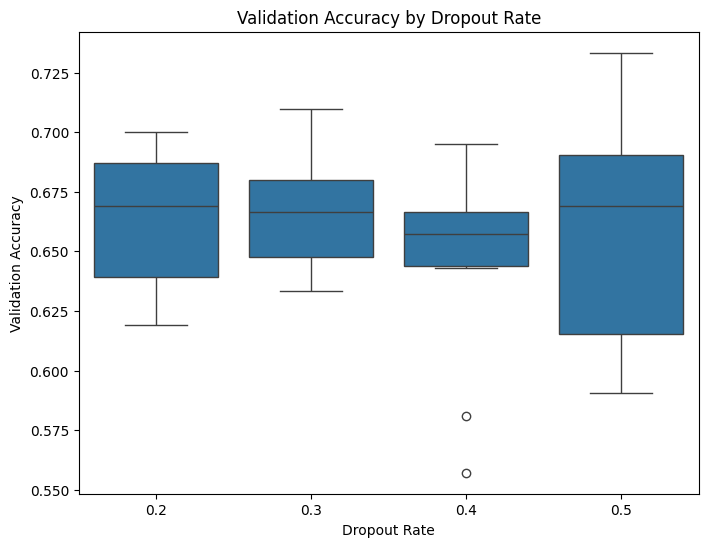

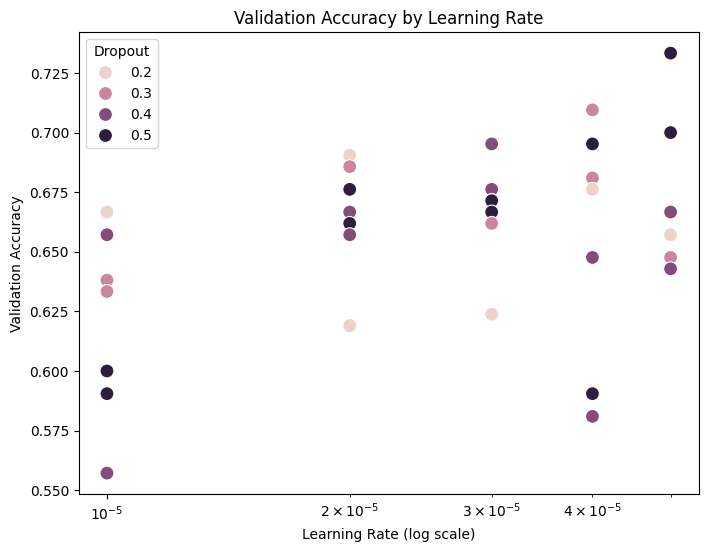

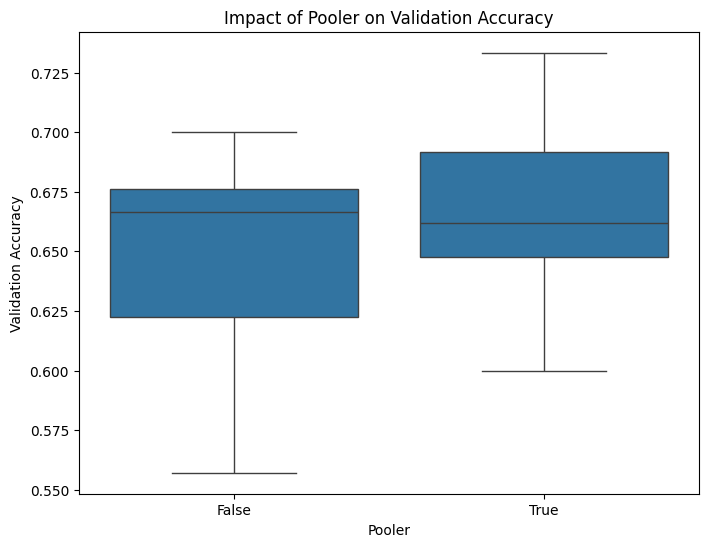

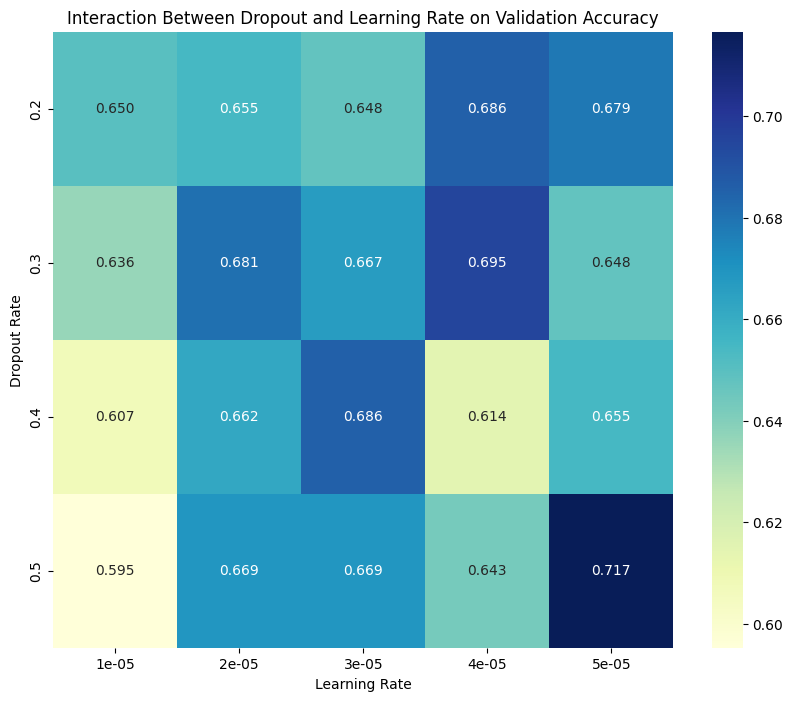

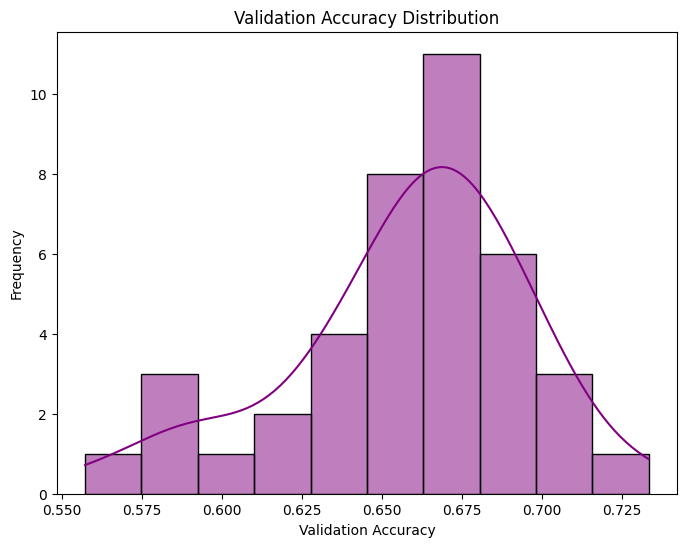

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot 1: Validation Accuracy by Dropout Rate
plt.figure(figsize=(8, 6))
sns.boxplot(x='dropout', y='val_accuracy', data=sorted_data)
plt.title('Validation Accuracy by Dropout Rate')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.show()

# Plot 2: Validation Accuracy by Learning Rate
plt.figure(figsize=(8, 6))
sns.scatterplot(x='learning_rate', y='val_accuracy', hue='dropout', data=sorted_data, s=100)
plt.title('Validation Accuracy by Learning Rate')
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation Accuracy')
plt.legend(title='Dropout')
plt.show()

# Plot 3: Impact of Pooler on Validation Accuracy
plt.figure(figsize=(8, 6))
sns.boxplot(x='pooler', y='val_accuracy', data=sorted_data)
plt.title('Impact of Pooler on Validation Accuracy')
plt.xlabel('Pooler')
plt.ylabel('Validation Accuracy')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

# Plot 4: Interaction Between Dropout and Learning Rate
plt.figure(figsize=(10, 8))
heatmap_data = sorted_data.pivot_table(index='dropout', columns='learning_rate', values='val_accuracy')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='YlGnBu')
plt.title('Interaction Between Dropout and Learning Rate on Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Dropout Rate')
plt.show()

# Plot 5: Validation Accuracy Distribution
plt.figure(figsize=(8, 6))
sns.histplot(sorted_data['val_accuracy'], kde=True, color='purple', bins=10)
plt.title('Validation Accuracy Distribution')
plt.xlabel('Validation Accuracy')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# export data so I can work with it in a new notebook without a GPU

sorted_data.to_csv('/content/drive/MyDrive/w266/Final Project/meral_results/hyperparameter_tuning_results.csv', index=False)

## Refined Grid Search

After narrowing down which parameters I'm interested in (see meral_gridseach_analysis.ipynb), I am going to run the two most promising hyperparameter sets x3 each, to see which produces the most stable results.

ClimateBERT:
1.   dropout 0.2, learning rate 5e-5, pooler=True
2.   dropout 0.3, learning rate 4e-5, pooler=True

**Answer: dropout 0.3, learning rate 4e-5, seed 2, Pooler True**

In [ ]:
# Define the two promising hyperparameter sets
hyperparameter_sets = [
    {'dropout': 0.2, 'learning_rate': 5e-5, 'pooler': True},
    {'dropout': 0.3, 'learning_rate': 4e-5, 'pooler': True}
]

# Prepare a list to store the results
results2 = []

# Loop through each hyperparameter set and run it 3 times with different random seeds
for hyperparams in hyperparameter_sets:
    for seed in range(3):  # Run 3 times with different seeds
        np.random.seed(seed)
        tf.random.set_seed(seed)

        # Extract hyperparameters
        dropout = hyperparams['dropout']
        learning_rate = hyperparams['learning_rate']
        pooler = hyperparams['pooler']

        # Create the model with the current hyperparameters
        model = create_climatebert_multiclass_model(
            checkpoint=checkpoint_2,
            num_classes=3,
            hidden_size=201,
            dropout=dropout,
            learning_rate=learning_rate,
            pooler=pooler
        )

        # Train model
        history = model.fit(
            [x_train.input_ids, x_train.attention_mask],
            train_sentiment,
            validation_split=0.1,  # split 10% of data for validation
            batch_size=8,
            epochs=1
        )

        # Record the validation accuracy for the last epoch
        val_acc = history.history['val_accuracy'][-1]

        # Append results to results2
        results2.append({
            'dropout': dropout,
            'learning_rate': learning_rate,
            'pooler': pooler,
            'seed': seed,
            'val_accuracy': val_acc
        })

results2_df = pd.DataFrame(results2)

print(results2_df)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 100s 335ms/step - loss: 0.8410 - accuracy: 0.5968 - val_loss: 0.8215 - val_accuracy: 0.6429


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 344ms/step - loss: 0.8080 - accuracy: 0.6308 - val_loss: 0.6990 - val_accuracy: 0.6905


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 345ms/step - loss: 0.7903 - accuracy: 0.6440 - val_loss: 0.8135 - val_accuracy: 0.6857


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 101s 348ms/step - loss: 0.8417 - accuracy: 0.6138 - val_loss: 0.8059 - val_accuracy: 0.6476


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 100s 344ms/step - loss: 0.8298 - accuracy: 0.6249 - val_loss: 0.7274 - val_accuracy: 0.6667


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

236/236 [==============================] - 99s 345ms/step - loss: 0.8089 - accuracy: 0.6345 - val_loss: 0.7554 - val_accuracy: 0.7095
   dropout  learning_rate  pooler  seed  val_accuracy
0      0.2        0.00005    True     0      0.642857
1      0.2        0.00005    True     1      0.690476
2      0.2        0.00005    True     2      0.685714
3      0.3        0.00004    True     0      0.647619
4      0.3        0.00004    True     1      0.666667
5      0.3        0.00004    True     2      0.709524


In [ ]:
results2_df

,dropout,learning_rate,pooler,seed,val_accuracy
0,0.2,0.00005,True,0,0.642857
1,0.2,0.00005,True,1,0.690476
2,0.2,0.00005,True,2,0.685714
3,0.3,0.00004,True,0,0.647619
4,0.3,0.00004,True,1,0.666667
5,0.3,0.00004,True,2,0.709524


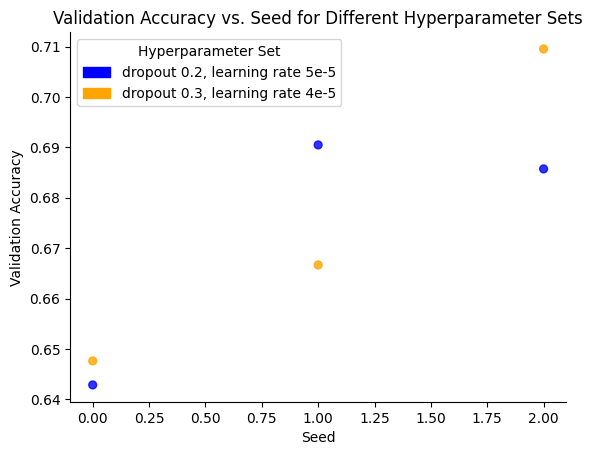

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Add a new column to classify parameter sets
results2_df['parameter_set'] = results2_df.apply(
    lambda row: 'Set 1' if row['dropout'] == 0.2 and row['learning_rate'] == 5e-5 else 'Set 2',
    axis=1
)

# Create a scatter plot with 'seed' on the x-axis and 'val_accuracy' on the y-axis
ax = results2_df.plot(kind='scatter', x='seed', y='val_accuracy', s=32, alpha=0.8,
                      c=results2_df['parameter_set'].map({'Set 1': 'blue', 'Set 2': 'orange'}))

# Remove the top and right spines for a cleaner plot
plt.gca().spines[['top', 'right']].set_visible(False)

# Add title and labels
plt.title('Validation Accuracy vs. Seed for Different Hyperparameter Sets')
plt.xlabel('Seed')
plt.ylabel('Validation Accuracy')

# Create custom legend entries for the two hyperparameter sets
set1_patch = mpatches.Patch(color='blue', label='dropout 0.2, learning rate 5e-5')
set2_patch = mpatches.Patch(color='orange', label='dropout 0.3, learning rate 4e-5')

# Add the custom legend
plt.legend(handles=[set1_patch, set2_patch], title='Hyperparameter Set')

plt.show()


Seed 2 is also better here. Looks like dropout 3, learning rate 4e-5 is the winner!

## Epoch tests

**Answer: 3 epochs**

In [ ]:
# Prepare a list to store the results
results3 = []

# Loop through different epoch values (1 to 5)
for epoch in range(1, 6):  # Epochs from 1 to 5
    np.random.seed(2)
    tf.random.set_seed(2)

    # Create the model with the current hyperparameters
    model = create_climatebert_multiclass_model(
        checkpoint=checkpoint_2,
        num_classes=3,
        hidden_size=201,
        dropout=0.3,
        learning_rate=4e-5,
        pooler=True
    )

    # Train model with the current number of epochs
    history = model.fit(
        [x_train.input_ids, x_train.attention_mask],
        train_sentiment,
        validation_split=0.1,  # split 10% of data for validation
        batch_size=8,
        epochs=epoch,
        verbose=1
    )

    # Loop through the history for each epoch to save the metrics
    for e in range(epoch):
        train_loss = history.history['loss'][e]
        train_accuracy = history.history['accuracy'][e]
        val_loss = history.history['val_loss'][e]
        val_accuracy = history.history['val_accuracy'][e]

        # Append results for each epoch
        results3.append({
            'epoch': e + 1,  # Adjusted to reflect actual epoch number (starting from 1)
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        })

# After the loop, convert the results into a DataFrame named results3_df
results3_df = pd.DataFrame(results3)

# Display the results
print(results3_df)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

236/236 [==============================] - 96s 324ms/step - loss: 0.8214 - accuracy: 0.6223 - val_loss: 0.7761 - val_accuracy: 0.6952


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/2
236/236 [==============================] - 97s 331ms/step - loss: 0.8066 - accuracy: 0.6408 - val_loss: 0.7326 - val_accuracy: 0.6952
Epoch 2/2
236/236 [==============================] - 75s 317ms/step - loss: 0.4894 - accuracy: 0.8101 - val_loss: 0.6627 - val_accuracy: 0.7333


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/3
236/236 [==============================] - 99s 338ms/step - loss: 0.8203 - accuracy: 0.6387 - val_loss: 0.7596 - val_accuracy: 0.6762
Epoch 2/3
236/236 [==============================] - 75s 318ms/step - loss: 0.4773 - accuracy: 0.8154 - val_loss: 0.7626 - val_accuracy: 0.6952
Epoch 3/3
236/236 [==============================] - 75s 317ms/step - loss: 0.2303 - accuracy: 0.9167 - val_loss: 0.9473 - val_accuracy: 0.7143


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/4
236/236 [==============================] - 100s 338ms/step - loss: 0.8058 - accuracy: 0.6382 - val_loss: 0.7688 - val_accuracy: 0.7238
Epoch 2/4
236/236 [==============================] - 75s 318ms/step - loss: 0.5145 - accuracy: 0.8149 - val_loss: 0.6596 - val_accuracy: 0.7429
Epoch 3/4
236/236 [==============================] - 75s 318ms/step - loss: 0.2323 - accuracy: 0.9141 - val_loss: 0.7814 - val_accuracy: 0.7286
Epoch 4/4
236/236 [==============================] - 75s 317ms/step - loss: 0.1443 - accuracy: 0.9512 - val_loss: 1.0813 - val_accuracy: 0.7524


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/5
236/236 [==============================] - 100s 339ms/step - loss: 0.8084 - accuracy: 0.6440 - val_loss: 0.7490 - val_accuracy: 0.6905
Epoch 2/5
236/236 [==============================] - 75s 318ms/step - loss: 0.4840 - accuracy: 0.8143 - val_loss: 0.7356 - val_accuracy: 0.7190
Epoch 3/5
236/236 [==============================] - 75s 317ms/step - loss: 0.2500 - accuracy: 0.9082 - val_loss: 0.7681 - val_accuracy: 0.7190
Epoch 4/5
236/236 [==============================] - 75s 317ms/step - loss: 0.1153 - accuracy: 0.9607 - val_loss: 0.9246 - val_accuracy: 0.7381
Epoch 5/5
236/236 [==============================] - 75s 318ms/step - loss: 0.0816 - accuracy: 0.9724 - val_loss: 1.3151 - val_accuracy: 0.7000
    epoch  train_loss  train_accuracy  val_loss  val_accuracy
0       1    0.821439        0.622281  0.776094      0.695238
1       1    0.806566        0.640849  0.732634      0.695238
2       2    0.489401        0.810080  0.662665      0.733333
3       1    0.820307        0.

In [ ]:
total_num_epochs = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5]
results3_df['total_num_epochs'] = total_num_epochs
results3_df = results3_df[['epoch', 'total_num_epochs', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']]
results3_df

,epoch,total_num_epochs,train_loss,train_accuracy,val_loss,val_accuracy
0,1,1,0.821439,0.622281,0.776094,0.695238
1,1,2,0.806566,0.640849,0.732634,0.695238
2,2,2,0.489401,0.810080,0.662665,0.733333
3,1,3,0.820307,0.638727,0.759558,0.676190
4,2,3,0.477260,0.815385,0.762640,0.695238
5,3,3,0.230324,0.916711,0.947333,0.714286
6,1,4,0.805809,0.638196,0.768759,0.723810
7,2,4,0.514512,0.814854,0.659613,0.742857
8,3,4,0.232323,0.914058,0.781425,0.728571
9,4,4,0.144255,0.951194,1.081301,0.752381


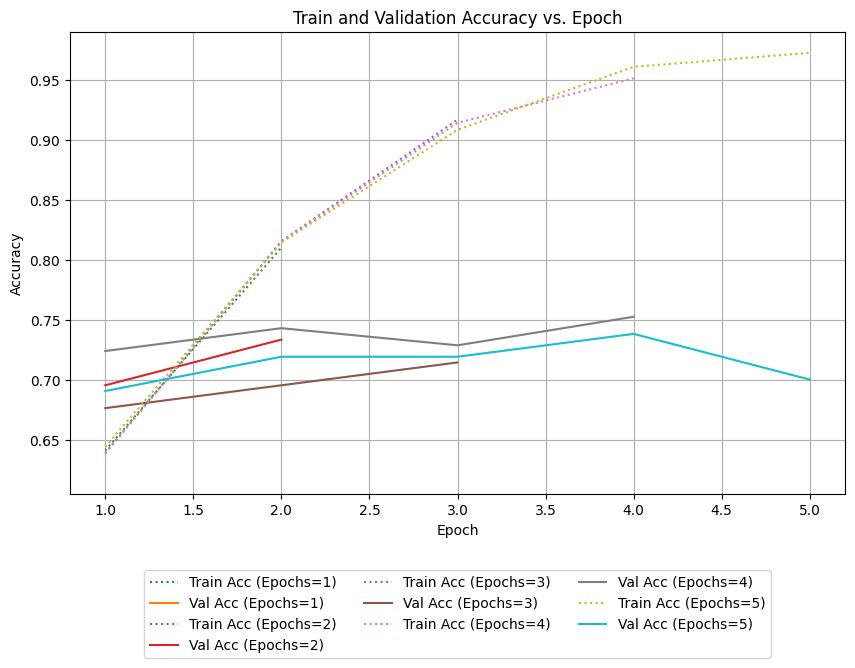

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Loop over unique values of 'total_num_epochs'
for total_epochs in results3_df['total_num_epochs'].unique():
    subset = results3_df[results3_df['total_num_epochs'] == total_epochs]

    # Plot train accuracy (dotted line)
    plt.plot(subset['epoch'], subset['train_accuracy'], linestyle='dotted', label=f'Train Acc (Epochs={total_epochs})')

    # Plot validation accuracy (solid line)
    plt.plot(subset['epoch'], subset['val_accuracy'], linestyle='solid', label=f'Val Acc (Epochs={total_epochs})')

# Labeling axes and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy vs. Epoch')

# Move the legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Add grid
plt.grid(True)

plt.show()


I'm going to try to implement early stopping and see if that makes a difference.

In [ ]:
# Early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model = create_climatebert_multiclass_model(
        checkpoint=checkpoint_2,
        num_classes=3,
        hidden_size=201,
        dropout=0.3,
        learning_rate=4e-5,
        pooler=True
)

# Train model with the current number of epochs
history = model.fit(
        [x_train.input_ids, x_train.attention_mask],
        train_sentiment,
        validation_split=0.1,  # split 10% of data for validation
        batch_size=8,
        epochs=7,
        callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

Epoch 1/7
236/236 [==============================] - 102s 342ms/step - loss: 0.8233 - accuracy: 0.6382 - val_loss: 0.7624 - val_accuracy: 0.6667
Epoch 2/7
236/236 [==============================] - 76s 320ms/step - loss: 0.5242 - accuracy: 0.7984 - val_loss: 0.6936 - val_accuracy: 0.7000
Epoch 3/7
236/236 [==============================] - 75s 318ms/step - loss: 0.2815 - accuracy: 0.8918 - val_loss: 0.7585 - val_accuracy: 0.7286
Epoch 4/7
236/236 [==============================] - 75s 318ms/step - loss: 0.1547 - accuracy: 0.9485 - val_loss: 1.0787 - val_accuracy: 0.7095
Epoch 5/7
236/236 [==============================] - 75s 318ms/step - loss: 0.0753 - accuracy: 0.9735 - val_loss: 1.2114 - val_accuracy: 0.7000
Epoch 6/7
236/236 [==============================] - 75s 318ms/step - loss: 0.0507 - accuracy: 0.9814 - val_loss: 1.4018 - val_accuracy: 0.7238
Epoch 7/7
236/236 [==============================] - 75s 320ms/step - loss: 0.0357 - accuracy: 0.9889 - val_loss: 1.9818 - val_accuracy

Looks like 3 epochs is good. After this, val loss increases while training loss keeps decreasing, indicating overfitting.

## Class Weights

**Answer: {0: 0.8763365876336587, 1: 2.05, 2: 0.7340342679127726}**

### Imports and CM Function

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split the data into the first 90% for training and the last 10% for evaluation
split_index = int(0.9 * len(x_train['input_ids']))  # Use length of input_ids (same length for all keys)

# Create training and validation subsets
x_train_subset = {
    'input_ids': x_train['input_ids'][:split_index],
    'attention_mask': x_train['attention_mask'][:split_index]
    }

train_sentiment_subset = train_sentiment[:split_index]

x_val_subset = {
    'input_ids': x_train['input_ids'][split_index:],  # Last 10% for validation
    'attention_mask': x_train['attention_mask'][split_index:]
}

y_val_subset = train_sentiment[split_index:]  # Validation labels

In [ ]:
# Function to make confusion matrices

def my_confusion_matrix(y_val_subset, predictions_class):
    # Generate the confusion matrix
    cm = confusion_matrix(y_val_subset, predictions_class)

    # Create a new figure and plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[0, 1, 2], yticklabels=[0, 1, 2],
                ax=ax, vmin=0, vmax=80)

    # Add labels and title
    ax.set_title("Confusion Matrix Heatmap")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

    # Close the plot automatically to avoid double rendering in notebooks
    plt.close(fig)

    return fig

### Test Inverse Class Weights

/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

Epoch 1/3
236/236 [==============================] - 78s 241ms/step - loss: 2.5140 - accuracy: 0.6164 - val_loss: 0.7815 - val_accuracy: 0.6762
Epoch 2/3
236/236 [==============================] - 55s 233ms/step - loss: 1.5000 - accuracy: 0.8032 - val_loss: 0.8282 - val_accuracy: 0.6905
Epoch 3/3
7/7 [==============================] - 3s 250ms/step
              precision    recall  f1-score   support

           0       0.69      0.49      0.57        71
           1       0.71      0.84      0.77        49
           2       0.73      0.82      0.77        90

    accuracy                           0.71       210
   macro avg       0.71      0.72      0.70       210
weighted avg       0.71      0.71      0.70       210



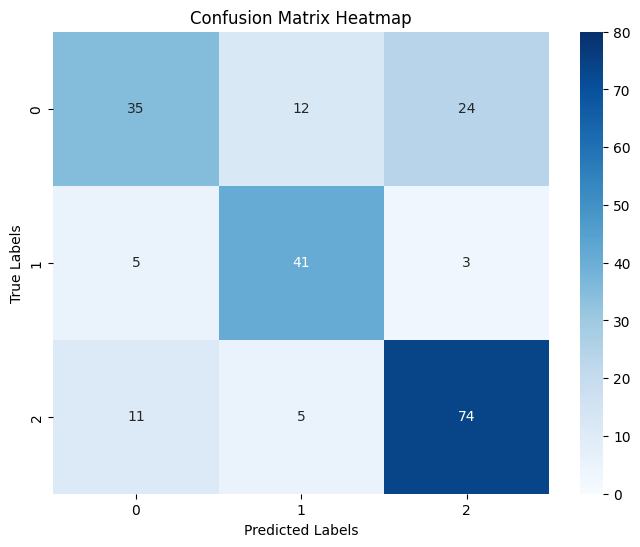

In [ ]:
class_weights = {0: 2.63, 1: 5.74, 2: 2.25}  # Inverse frequency counts

# Create the model
model = create_climatebert_multiclass_model(
    checkpoint=checkpoint_2,
    num_classes=3,
    hidden_size=201,
    dropout=0.3,
    learning_rate=4e-5,
    pooler=True
)

# Train the model on the first 90% of the data
history = model.fit(
    [x_train_subset['input_ids'], x_train_subset['attention_mask']],
    train_sentiment_subset,
    validation_data=(
        [x_val_subset['input_ids'], x_val_subset['attention_mask']],
        y_val_subset
    ),
    batch_size=8,
    epochs=3,
    class_weight=class_weights
)

# Evaluate on the last 10% of data
predictions = model.predict(
    [x_val_subset['input_ids'], x_val_subset['attention_mask']]
)

predictions_class = predictions.argmax(axis=-1)

# Generate the classification report
print(classification_report(y_val_subset, predictions_class))

cm1 = my_confusion_matrix(y_val_subset, predictions_class)
cm1

### No Class Weights Baseline

/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

Epoch 1/3
236/236 [==============================] - 81s 254ms/step - loss: 0.8240 - accuracy: 0.6286 - val_loss: 0.6925 - val_accuracy: 0.6905
Epoch 2/3
236/236 [==============================] - 55s 232ms/step - loss: 0.4924 - accuracy: 0.8164 - val_loss: 0.6774 - val_accuracy: 0.7095
Epoch 3/3
7/7 [==============================] - 3s 249ms/step
              precision    recall  f1-score   support

           0       0.54      0.75      0.62        71
           1       0.83      0.49      0.62        49
           2       0.82      0.74      0.78        90

    accuracy                           0.69       210
   macro avg       0.73      0.66      0.67       210
weighted avg       0.72      0.69      0.69       210



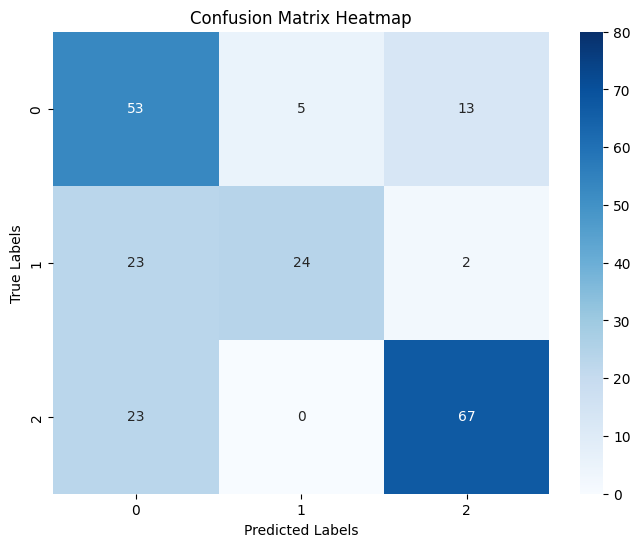

In [ ]:
# Create the model
model = create_climatebert_multiclass_model(
    checkpoint=checkpoint_2,
    num_classes=3,
    hidden_size=201,
    dropout=0.3,
    learning_rate=4e-5,
    pooler=True
)

# Train the model on the first 90% of the data
history = model.fit(
    [x_train_subset['input_ids'], x_train_subset['attention_mask']],
    train_sentiment_subset,
    validation_data=(
        [x_val_subset['input_ids'], x_val_subset['attention_mask']],
        y_val_subset
    ),
    batch_size=8,
    epochs=3)

# Evaluate on the last 10% of data
predictions = model.predict(
    [x_val_subset['input_ids'], x_val_subset['attention_mask']]
)

predictions_class = predictions.argmax(axis=-1)

# Generate the classification report
print(classification_report(y_val_subset, predictions_class))

cm2 = my_confusion_matrix(y_val_subset, predictions_class)
cm2

### Compute_Class_Weight

Computed Class Weights: {0: 0.8763365876336587, 1: 2.013888888888889, 2: 0.7340342679127726}


/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

Epoch 1/3
236/236 [==============================] - 82s 254ms/step - loss: 0.8911 - accuracy: 0.5915 - val_loss: 0.7789 - val_accuracy: 0.6143
Epoch 2/3
236/236 [==============================] - 55s 233ms/step - loss: 0.5248 - accuracy: 0.7931 - val_loss: 0.7481 - val_accuracy: 0.6810
Epoch 3/3
7/7 [==============================] - 3s 250ms/step
              precision    recall  f1-score   support

           0       0.61      0.65      0.63        71
           1       0.62      0.67      0.65        49
           2       0.80      0.73      0.77        90

    accuracy                           0.69       210
   macro avg       0.68      0.68      0.68       210
weighted avg       0.70      0.69      0.69       210



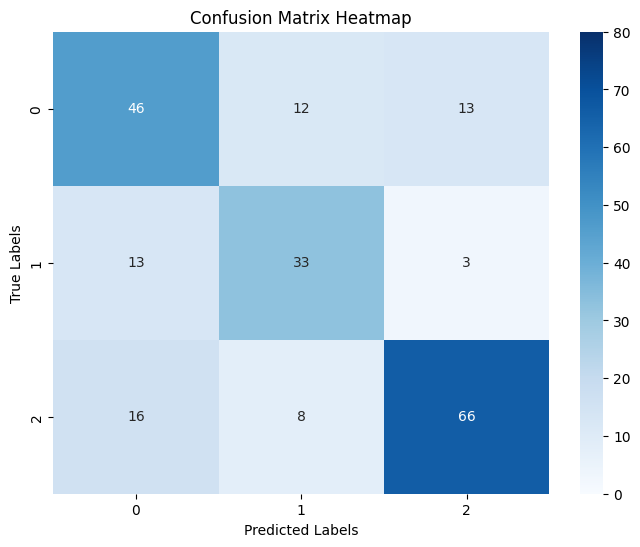

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Convert train_sentiment_subset to a numpy array if it's a tensor
train_sentiment_subset_np = train_sentiment_subset.numpy() if hasattr(train_sentiment_subset, 'numpy') else train_sentiment_subset

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',  # Automatically computes weights inversely proportional to class frequencies
    classes=np.unique(train_sentiment_subset_np),  # Unique classes (0, 1, 2, etc.)
    y=train_sentiment_subset_np  # Target array of labels
)

# Convert the class weights into a dictionary (class -> weight)
class_weights = {i: class_weights_array[i] for i in np.unique(train_sentiment_subset_np)}

# Print the class weights to check
print("Computed Class Weights:", class_weights)

# Create the model
model = create_climatebert_multiclass_model(
    checkpoint=checkpoint_2,
    num_classes=3,
    hidden_size=201,
    dropout=0.3,
    learning_rate=4e-5,
    pooler=True
)

# Train the model on the first 90% of the data
history = model.fit(
    [x_train_subset['input_ids'], x_train_subset['attention_mask']],
    train_sentiment_subset,
    validation_data=(
        [x_val_subset['input_ids'], x_val_subset['attention_mask']],
        y_val_subset
    ),
    batch_size=8,
    epochs=3,
    class_weight=class_weights
)

# Evaluate on the last 10% of data
predictions = model.predict(
    [x_val_subset['input_ids'], x_val_subset['attention_mask']]
)

predictions_class = predictions.argmax(axis=-1)

# Generate the classification report
print(classification_report(y_val_subset, predictions_class))

cm3 = my_confusion_matrix(y_val_subset, predictions_class)
cm3

### Manually Adjust Compute_Class_Weight

/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

Epoch 1/3
236/236 [==============================] - 83s 260ms/step - loss: 0.8992 - accuracy: 0.5698 - val_loss: 0.7863 - val_accuracy: 0.6000
Epoch 2/3
236/236 [==============================] - 55s 232ms/step - loss: 0.5182 - accuracy: 0.7894 - val_loss: 0.6442 - val_accuracy: 0.7143
Epoch 3/3
7/7 [==============================] - 3s 251ms/step
              precision    recall  f1-score   support

           0       0.59      0.85      0.70        71
           1       0.69      0.71      0.70        49
           2       0.95      0.61      0.74        90

    accuracy                           0.71       210
   macro avg       0.74      0.72      0.71       210
weighted avg       0.77      0.71      0.72       210



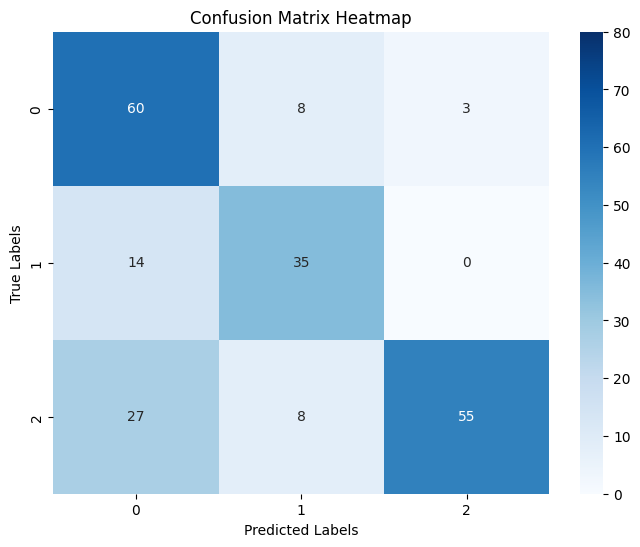

In [ ]:
class_weights = {0: 0.8763365876336587, 1: 2.05, 2: 0.7340342679127726}  # Increase 1's weight

# Create the model
model = create_climatebert_multiclass_model(
    checkpoint=checkpoint_2,
    num_classes=3,
    hidden_size=201,
    dropout=0.3,
    learning_rate=4e-5,
    pooler=True
)

# Train the model on the first 90% of the data
history = model.fit(
    [x_train_subset['input_ids'], x_train_subset['attention_mask']],
    train_sentiment_subset,
    validation_data=(
        [x_val_subset['input_ids'], x_val_subset['attention_mask']],
        y_val_subset
    ),
    batch_size=8,
    epochs=3,
    class_weight=class_weights
)

# Evaluate on the last 10% of data
predictions = model.predict(
    [x_val_subset['input_ids'], x_val_subset['attention_mask']]
)

predictions_class = predictions.argmax(axis=-1)

# Generate the classification report
print(classification_report(y_val_subset, predictions_class))

cm4 = my_confusion_matrix(y_val_subset, predictions_class)
cm4

### Confusion Matrix Results

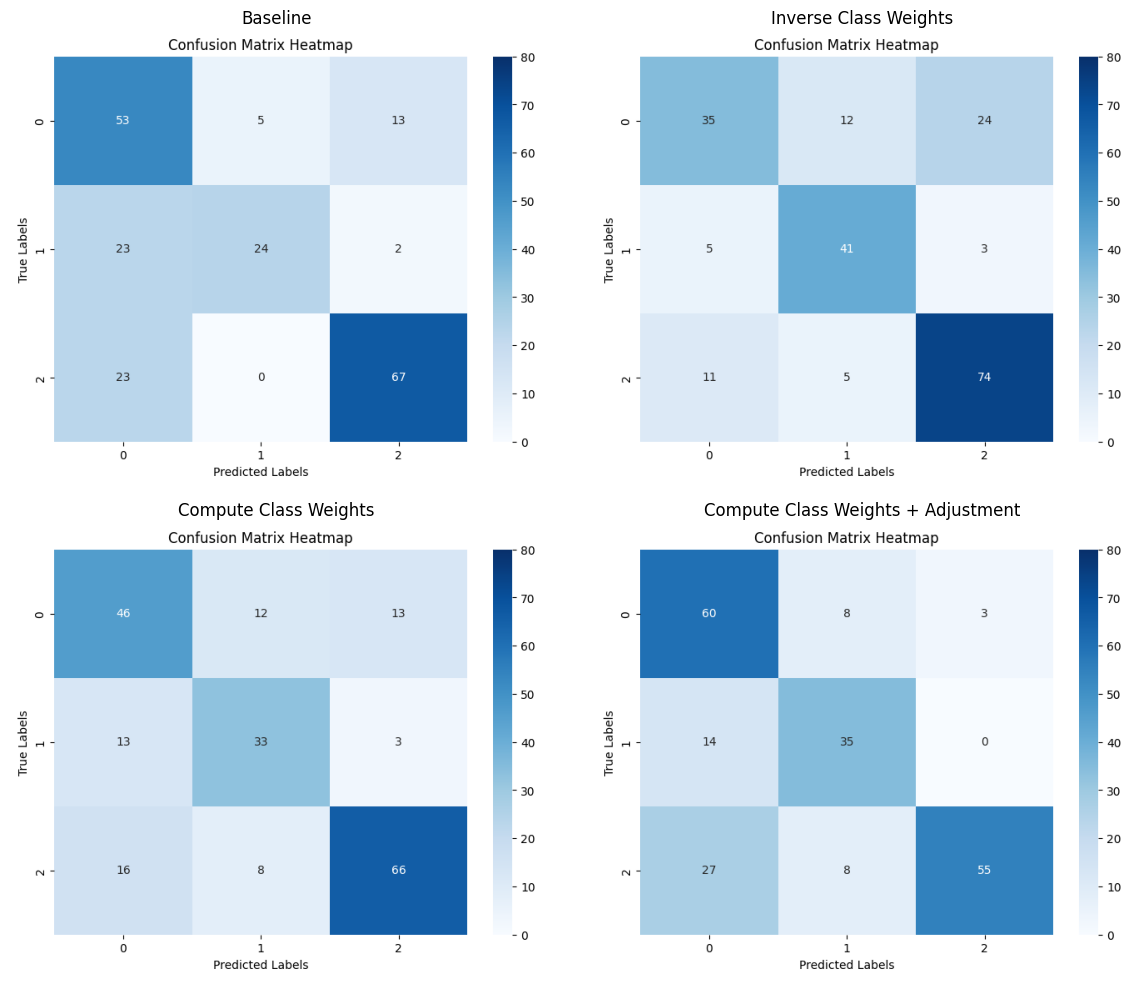

In [ ]:
# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Display each confusion matrix in the grid
axes[0, 0].imshow(cm2.canvas.buffer_rgba())
axes[0, 1].imshow(cm1.canvas.buffer_rgba())
axes[1, 0].imshow(cm3.canvas.buffer_rgba())
axes[1, 1].imshow(cm4.canvas.buffer_rgba())

# Add titles for each subplot
axes[0, 0].set_title("Baseline")
axes[0, 1].set_title("Inverse Class Weights")
axes[1, 0].set_title("Compute Class Weights")
axes[1, 1].set_title("Compute Class Weights + Adjustment")

# Remove axes and ticks for each subplot
for ax in axes.flat:
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

### Conclusion

Looks like inverse class weights plus adjustment has the highest weighed average F1 score and is tied for the highest accuracy. Let's pick **inverse + adjustment**

Weights: {0: 0.8763365876336587, 1: 2.05, 2: 0.7340342679127726}

## Final Specifications

* Dropout 0.3
* Learning Rate 4e-5
* Seed 2
* Epochs 3
* Pooler True
* Class Weights {0: 0.8763365876336587, 1: 2.05, 2: 0.7340342679127726}

# Test Results

In [ ]:
class_weights = {0: 0.8763365876336587, 1: 2.05, 2: 0.7340342679127726}  # Increase 1's weight

# Set Random Seeds
np.random.seed(2)
tf.random.set_seed(2)

# Create the model
test_model = create_climatebert_multiclass_model(
    checkpoint=checkpoint_2,
    num_classes=3,
    hidden_size=201,
    dropout=0.3,
    learning_rate=4e-5,
    pooler=True
)

# Train the model on the first 90% of the data
history = test_model.fit(
    [x_train['input_ids'], x_train['attention_mask']],
    train_sentiment,
    validation_split=0.1,
    batch_size=8,
    epochs=3,
    class_weight=class_weights
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/3
236/236 [==============================] - 83s 257ms/step - loss: 0.9147 - accuracy: 0.5586 - val_loss: 0.6808 - val_accuracy: 0.7048
Epoch 2/3
236/236 [==============================] - 55s 232ms/step - loss: 0.5272 - accuracy: 0.7947 - val_loss: 0.8968 - val_accuracy: 0.6762
Epoch 3/3
236/236 [==============================] - 55s 233ms/step - loss: 0.2706 - accuracy: 0.8944 - val_loss: 0.7861 - val_accuracy: 0.7286


7/7 [==============================] - 2s 237ms/step
              precision    recall  f1-score   support

           0       0.66      0.81      0.73        85
           1       0.71      0.62      0.66        39
           2       0.82      0.67      0.74        76

    accuracy                           0.72       200
   macro avg       0.73      0.70      0.71       200
weighted avg       0.73      0.72      0.72       200



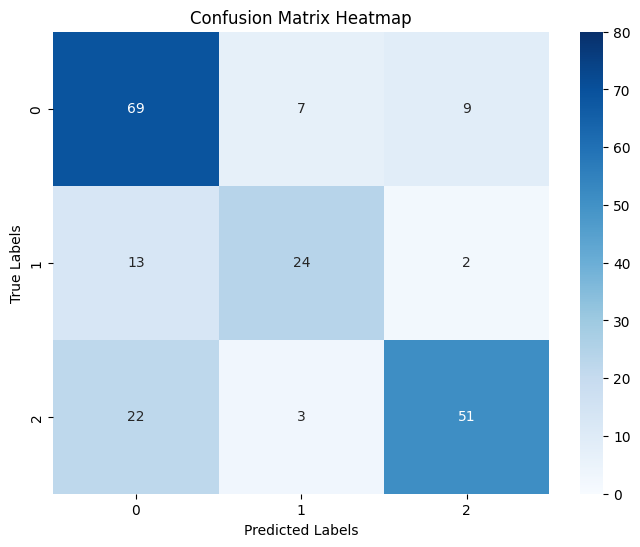

In [ ]:
# Evaluate on the test data
predictions = test_model.predict(
    [x_test['input_ids'], x_test['attention_mask']]
)

predictions_class = predictions.argmax(axis=-1)

# Generate the classification report
print(classification_report(test_sentiment, predictions_class))

cm_test = my_confusion_matrix(test_sentiment, predictions_class)
cm_test

In [ ]:
print(predictions_class)
df_predictions = pd.DataFrame(predictions_class, columns=['Predictions'])
df_predictions.to_csv('/content/drive/MyDrive/w266/Final Project/meral_results/climateBERT_test_results.csv', index=False)

[0 0 2 1 2 1 1 1 0 1 0 0 2 0 0 0 0 0 0 1 0 2 2 0 2 1 0 1 2 0 2 0 2 0 0 1 0
 0 0 2 2 0 0 0 0 0 2 0 0 1 2 0 0 0 0 2 2 0 2 1 2 2 0 0 2 2 1 2 0 0 1 0 0 2
 0 0 2 0 0 0 2 0 0 1 0 0 1 1 1 0 0 2 1 0 2 2 2 0 0 0 2 2 2 2 2 0 0 1 0 0 1
 2 0 0 1 1 0 2 1 0 2 0 2 0 1 0 1 0 2 2 1 0 2 2 0 0 2 1 0 0 2 2 0 2 0 2 0 1
 0 0 0 0 1 0 0 1 2 0 0 2 0 0 1 0 2 1 2 0 0 2 0 2 0 2 2 1 2 0 0 1 0 0 2 0 0
 2 0 2 0 0 0 0 2 0 2 2 2 0 0 0]
